In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib
font = {'family': 'Yu Mincho'}
matplotlib.rc('font', **font)

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)

import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from geopy.distance import great_circle, vincenty
from tqdm import tqdm
import mojimoji
import os
import gc
import plotly.express as px
import japanize_matplotlib
# print(os.listdir("././input"))
# print(os.listdir("././submit"))

SEED=1234
n_splits=10

In [10]:
train = pd.read_csv('./input/best_train.csv')
test = pd.read_csv('./input/best_test.csv')
# id_max = train.id.max()
df = pd.concat([train, test]).reset_index(drop=True)
print('訓練データ : ', train.shape)
print('テストデータ : ',test.shape)

訓練データ :  (86661, 22)
テストデータ :  (85991, 22)


In [13]:
def get_center_dis(df,col,lat,lon):
    '''
    国会議事堂からの距離を求める関数
    '''
    df[col] = df.apply(lambda x: vincenty((x['loc_lat'],x['loc_lon']),(lat,lon)).meters, axis=1)
    return df

In [14]:
def get_center_dis(df,col,lat,lon):
    '''
    国会議事堂からの距離を求める関数
    '''
    df[col] = df.apply(lambda x: vincenty((x['loc_lat'],x['loc_lon']),(lat,lon)).meters, axis=1)
    return df
#渋谷駅
train=get_center_dis(train,'center_dis2',(35.658034,139.701636))
test=get_center_dis(test,'center_dis2',(35.658034,139.701636))
#東京駅
train=get_center_dis(train,'center_dis3',(35.681236,139.767125))
test=get_center_dis(test,'center_dis3',(35.681236,139.767125))
#青山一丁目
train=get_center_dis(train,'center_dis4',(35.672857,139.723844))
test=get_center_dis(test,'center_dis4',(35.672857,139.723844))
#田園調布駅
train=get_center_dis(train,'center_dis4',(35.596867,139.667337))
test=get_center_dis(test,'center_dis4',(35.596867,139.667337))


NameError: name 'col1' is not defined

In [8]:
train_y=train['賃料']

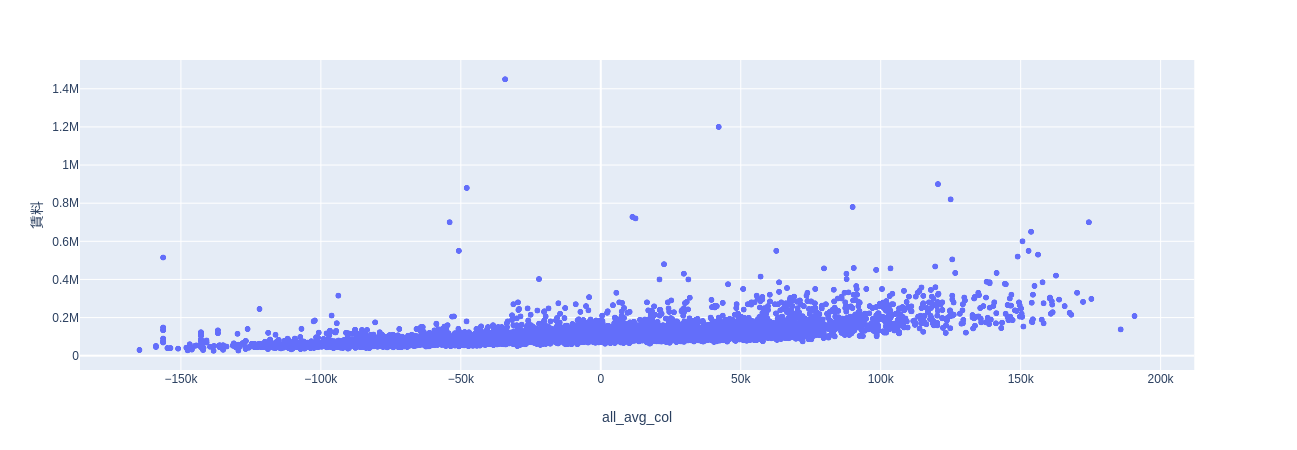

In [106]:
def onehot_TE(train,test,train_y,in_col,func):
    '''タブ区切り列からone-hot列を生成し、各列TEをmapする。それの列方向のsumを返す。
    その家においてある家財にと同じ家財がおいている人の平均賃料を出力する。
    内部で処理するので列をlist列にする必要はない
    '''

    def get_set_by_tabcols(data,in_col):
        '''リストになっている列の要素を網羅したリストを返す'''
        data2=data.copy()
        flatten =lambda nested_list:[e for inner_list in nested_list for e in inner_list]
        zen2han=lambda x :mojimoji.zen_to_han(x, kana=False)
        list_strip =lambda list_:[x for x in list_ if x]

        data2[in_col] = data2[in_col].fillna('None').apply(zen2han).str.replace('/', '')
        all_list = set(flatten(data2[in_col].str.split('\t').apply(list_strip).values))
        return all_list

    def checker(x,word):
        '''単語を含んでいるかどうかで0,1をつける'''
        return 1 if word in x else 0 


    all_list=get_set_by_tabcols(train,in_col)
    bin_tr=pd.DataFrame(np.zeros((train.shape[0],len(all_list))),columns=all_list)
    bin_te=pd.DataFrame(np.zeros((test.shape[0],len(all_list))),columns=all_list)
    bin_df=pd.DataFrame(np.zeros((2,len(all_list))),columns=all_list)

    #家財をおいているかどうか列ごとの0,1DataFrameを作成
    for word in all_list:
        bin_tr[word]=train.reset_index(drop=True)[in_col].fillna('None').apply(checker,word=word)
        bin_te[word]=test.reset_index(drop=True)[in_col].fillna('None').apply(checker,word=word)

    bin_tr['target']=train_y
    value=102000 if func=='median' else 118000
    
    #各列TEを適応
    for word in all_list:
        agg_series = bin_tr.groupby(word)['target'].agg(func)
        bin_tr[word]=bin_tr[word].map(agg_series).copy() -value
        bin_te[word]=bin_te[word].map(agg_series).copy() -value

    bin_tr.drop(columns='target',inplace=True)
    #平均を出力
    tr=bin_tr.sum(axis=1).astype(int)
    te=bin_te.sum(axis=1).astype(int)
#     return bin_df

    return tr,te
tab_cols=['バス・トイレ','キッチン','放送・通信','室内設備']
for i,in_col in enumerate(tab_cols):
#     if i==0:
#         bin_tr=onehot_TE2(train,test,train_y,col,'median')
#     else:
#         bin_tr=pd.concat([bin_tr,onehot_TE2(train,test,train_y,col,'median')],axis=1)
    train[in_col+'_TE'],test[in_col+'_TE']=onehot_TE(train,test,train_y,in_col,'mean')

In [107]:
train['all_TE']=train[TE_cols].mean(axis=1)
test['all_TE']=train[TE_cols].mean(axis=1)

train.columns

Index(['id', '賃料', '所在地', 'アクセス', '間取り', '築年数', '方角', '面積', '所在階', 'バス・トイレ',
       'キッチン', '放送・通信', '室内設備', '駐車場', '周辺環境', '建物構造', '契約期間',
       'バス・トイレavg_mean', 'キッチンavg_mean', '放送・通信avg_mean', '室内設備avg_mean',
       'bath_sum', 'all_avg_col', '室内設備_value', '室内設備_TE', 'バス・トイレ_TE',
       'キッチン_TE', '放送・通信_TE', 'all_TE'],
      dtype='object')

In [109]:
TE_cols=[col for col in train.columns if '_TE' in col]
TE_tr=train[TE_cols]
TE_te=test[TE_cols]

TE_tr['id']=train['id']
TE_te['id']=test['id']



In [110]:
TE_tr.to_csv('./input/TE_train.csv')
TE_te.to_csv('./input/TE_test.csv')

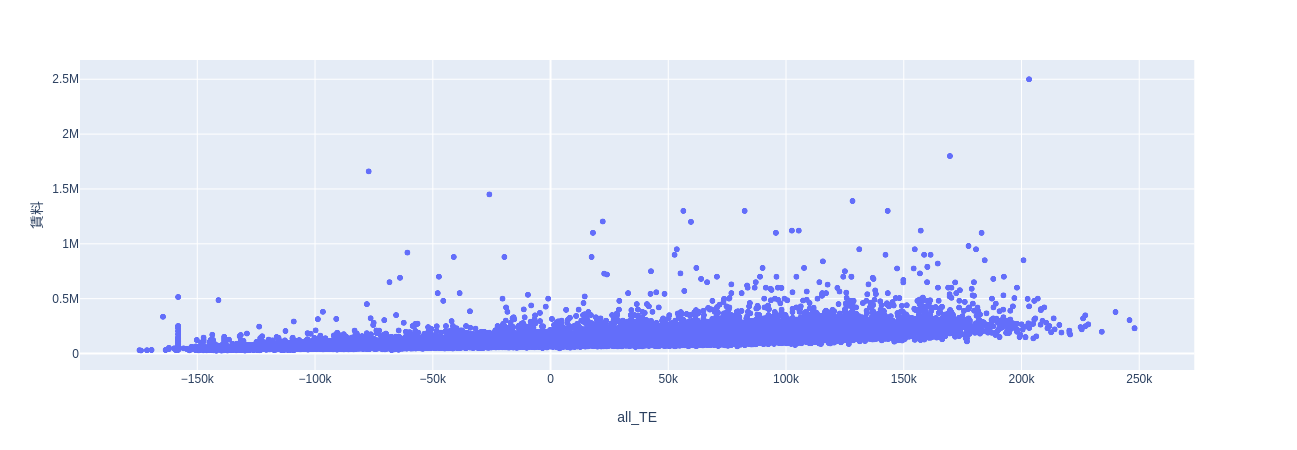

In [114]:
# train['bath_sum']=tr
# mini_train=train.head(5000)
fig = px.scatter(train, x="all_TE", y="賃料",text='id')
fig.show()

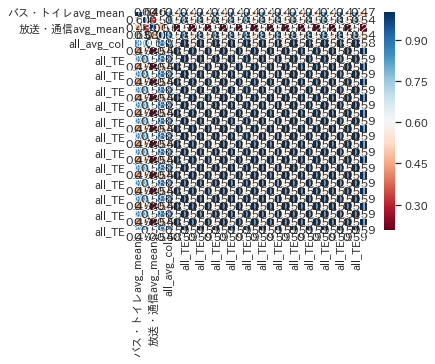

In [126]:
colormap = plt.cm.RdBu
# plt.figure()
TE_cols=[col for col in train.columns if '_TE' in col]
train['all_TE']=train[TE_cols].mean(axis=1)
# avg_cols+=['all_TE','賃料']
plt.figure(figsize=(14,12))
sns.heatmap(train[avg_cols].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
# plt.ylim(5.5,-0.5)
plt.show()
# plt.cla()

In [48]:
def onehot_TE(train,test,train_y,in_col,func):
    '''タブ区切り列からone-hot列を生成し、各列TEをmapする。それの列方向のsumを返す。
    その家においてある家財にと同じ家財がおいている人の平均賃料を出力する。
    内部で処理するので列をlist列にする必要はない
    '''

    def get_set_by_tabcols(data,in_col):
        '''リストになっている列の要素を網羅したリストを返す'''
        data2=data.copy()
        flatten =lambda nested_list:[e for inner_list in nested_list for e in inner_list]
        zen2han=lambda x :mojimoji.zen_to_han(x, kana=False)
        list_strip =lambda list_:[x for x in list_ if x]

        data2[in_col] = data2[in_col].fillna('None').apply(zen2han).str.replace('/', '')
        all_list = set(flatten(data2[in_col].str.split('\t').apply(list_strip).values))
        return all_list

    def checker(x,word):
        '''単語を含んでいるかどうかで0,1をつける'''
        return 1 if word in x else 0 


    all_list=get_set_by_tabcols(train,in_col)
    bin_tr=pd.DataFrame(np.zeros((train.shape[0],len(all_list))),columns=all_list)
    bin_te=pd.DataFrame(np.zeros((test.shape[0],len(all_list))),columns=all_list)
    bin_df=pd.DataFrame(np.zeros((2,len(all_list))),columns=all_list)

    #家財をおいているかどうか列ごとの0,1DataFrameを作成
    for word in all_list:
        bin_tr[word]=train.reset_index(drop=True)[in_col].fillna('None').apply(checker,word=word)
        bin_te[word]=test.reset_index(drop=True)[in_col].fillna('None').apply(checker,word=word)

    bin_tr['target']=train_y
    
    #各列TEを適応
    for word in all_list:  
        agg_series = bin_tr.groupby(word)['target'].agg(func)
        bin_tr[word]=bin_tr[word].map(agg_series).copy() -102000
        bin_te[word]=bin_te[word].map(agg_series).copy() -102000

    bin_tr.drop(columns='target',inplace=True)
    #平均を出力
    tr=bin_tr.mean(axis=1).astype(int)
    te=bin_te.mean(axis=1).astype(int)
#     return bin_df
    return tr,te
tab_cols=['バス・トイレ','キッチン','放送・通信','室内設備']
for i,col in enumerate(tab_cols):
#     if i==0:
#         bin_tr=onehot_TE2(train,test,train_y,col,'median')
#     else:
#         bin_tr=pd.concat([bin_tr,onehot_TE2(train,test,train_y,col,'median')],axis=1)
onehot_TE2(train,test,train_y,col,'median')

In [34]:
train['賃料'].median()

102000.0

In [42]:
bin_tr.head(4)

,共同トイレ,シャワー,バスなし,共同バス,脱衣所,温水洗浄便座,None,洗面台独立,追焚機能,専用トイレ,専用バス,バス・トイレ別,浴室乾燥機,冷蔵庫あり,コンロ3口,コンロ設置可(口数不明),コンロ設置可(コンロ3口),電気コンロ,IHコンロ,コンロ設置可(コンロ4口以上),None,コンロ設置可(コンロ2口),カウンターキッチン,コンロ2口,L字キッチン,独立キッチン,コンロ1口,コンロ4口以上,システムキッチン,コンロ設置可(コンロ1口),給湯,ガスコンロ,光ファイバー,BSアンテナ,インターネット使用料無料,None,CATV,高速インターネット,有線放送,CSアンテナ,インターネット対応,フローリング,24時間換気システム,2面採光,石油暖房,バリアフリー,室外洗濯機置場,ルーフバルコニー,井戸,防音室,専用庭,エアコン付,出窓,地下室,クッションフロア,バルコニー,ロフト付き,浄化槽,シューズボックス,None,オール電化,室内洗濯機置場,二世帯住宅,エレベーター,ペアガラス,下水,ウォークインクローゼット,プロパンガス,公営水道,トランクルーム,二重サッシ,床下収納,洗濯機置場なし,ガス暖房,冷房,水道その他,床暖房,タイル張り,汲み取り,3面採光,排水その他,敷地内ごみ置き場,ガスその他,都市ガス
0,-16290,-15290,-16290,-16290,-33290,-290,-16290,-47290,-32290,-13290,-12790,-9290,710,-16290,-25540,-16290,-16290,-16290,-15290,-16290,-16290,-16290,-22640,-16290,-17290,-20290,-12290,-16790,-1290,-16290,-17290,-9290,-20290,-4290,-20290,-14290,-14290,-17290,-16290,710,-10290,-13290,-27290,-19290,-16290,-16790,-14290,-17290,-16290,-16790,-16790,-16290,-16290,-16290,-16290,-11290,-15290,-16290,-9290,-16290,-17290,-12790,-16290,3210,-17290,-13290,-22290,-15290,-13290,-17290,-16790,-16790,-16290,-16290,-18290,-16290,-19290,-28290,-16290,-17290,-16290,-5290,-16290,-14290
1,-16290,-15290,-16290,-16290,-33290,-290,-16290,-47290,-32290,-13290,-32290,-56290,-38290,-16290,-25540,-16290,-16290,-16290,-15290,-16290,-16290,-16290,-22640,-19290,-17290,-20290,-12290,-16790,-1290,-16290,-17290,-9290,-20290,-29290,-20290,-14290,-18290,-17290,-16290,-26290,-10290,-13290,-27290,-19290,-16290,-16790,-14290,-17290,-16290,-16790,-16790,-16290,-16290,-16290,-16290,-11290,-15290,-16290,-9290,-16290,-17290,-12790,-16290,3210,-17290,-26290,-22290,-15290,-27290,-17290,-16790,-16790,-16290,-16290,-18290,-16290,-19290,-5290,-16290,-17290,-16290,-5290,-16290,-31290
2,-16290,-15290,-16290,-16290,7710,-290,-16290,1710,-32290,-13290,-12790,-9290,710,-16290,-25540,-16290,-16290,-16290,-15290,-16290,-16290,-16290,-22640,-16290,-17290,-20290,-12290,-16790,-1290,-16290,-17290,-9290,-13290,-4290,-20290,-14290,-18290,-17290,-16290,710,-10290,-13290,-27290,-19290,-16290,-16790,-14290,-17290,-16290,-16790,-16790,-16290,-16290,-16290,-16290,-11290,-15290,-16290,-9290,-16290,-17290,-12790,-16290,3210,-17290,-13290,42710,-15290,-13290,-17290,-16790,-16790,-16290,-16290,-18290,-16290,-19290,-5290,-16290,-17290,-16290,-5290,-16290,-14290
3,-16290,-15290,-16290,-16290,-33290,-290,-16290,1710,-32290,-13290,-12790,-9290,-38290,-16290,-25540,-16290,-16290,-16290,-15290,-16290,-16290,-16290,-22640,-19290,-17290,-20290,-12290,-16790,-45290,-16290,-17290,-9290,-13290,-29290,-20290,-14290,-18290,-17290,-16290,-26290,-10290,-41290,-27290,-5290,-16290,-16790,-14290,-17290,-16290,-16790,-16790,-16290,-16290,-16290,-16290,-11290,-15290,-16290,-9290,-16290,-17290,-12790,-16290,3210,-17290,-13290,-22290,-15290,-13290,-17290,-16790,-16790,-16290,-16290,-18290,-16290,-19290,-28290,-16290,-17290,-16290,-31290,-16290,-14290


In [31]:
bin_tr.head(500)

,共同トイレ,シャワー,バスなし,共同バス,脱衣所,温水洗浄便座,None,洗面台独立,追焚機能,専用トイレ,専用バス,バス・トイレ別,浴室乾燥機,冷蔵庫あり,コンロ3口,コンロ設置可(口数不明),コンロ設置可(コンロ3口),電気コンロ,IHコンロ,コンロ設置可(コンロ4口以上),None,コンロ設置可(コンロ2口),カウンターキッチン,コンロ2口,L字キッチン,独立キッチン,コンロ1口,コンロ4口以上,システムキッチン,コンロ設置可(コンロ1口),給湯,ガスコンロ,光ファイバー,BSアンテナ,インターネット使用料無料,None,CATV,高速インターネット,有線放送,CSアンテナ,インターネット対応,フローリング,24時間換気システム,2面採光,石油暖房,バリアフリー,室外洗濯機置場,ルーフバルコニー,井戸,防音室,専用庭,エアコン付,出窓,地下室,クッションフロア,バルコニー,ロフト付き,浄化槽,シューズボックス,None,オール電化,室内洗濯機置場,二世帯住宅,エレベーター,ペアガラス,下水,ウォークインクローゼット,プロパンガス,公営水道,トランクルーム,二重サッシ,床下収納,洗濯機置場なし,ガス暖房,冷房,水道その他,床暖房,タイル張り,汲み取り,3面採光,排水その他,敷地内ごみ置き場,ガスその他,都市ガス
0,0,-12000,0,0,-17000,-23000,0,-31000,-16000,-11000,-16000,-40000,-22000,0,-9250,0.0,0.0,0,1000,0.0,0,0.0,-6350,-3000,-1000,-4000,4000,-500,-29000,0.0,4000,-17000,-4000,-13000,-4000,2000,-2000,-1000,0,-10000,-10500,-25000,-11000,-3000,0,-500,2000,-1000,0,-500,-500,-9000,0,0,0,-28000,1000,0,-24000,0,-1000,-36000,0,-22000,-1000,-10000,-6000,1000,-11000,-1000,-500,-500,0,0,-2000,0,-3000,-12000,0,-1000,0,-15000,0,-15000
1,-59900,1000,-45000,-50000,24000,16000,-40000,18000,33000,3000,3500,7000,17000,-37500,72000,NaN,NaN,-35000,-13000,NaN,-33000,NaN,56000,0,103000,23000,-33000,148000,15000,NaN,-1000,7000,3000,12000,9000,-22000,2000,5000,5000,17000,6000,3000,18000,11000,-27000,89000,-37000,53000,-27000,23000,34000,0,-4000,91000,-26500,5000,-37000,-17000,7000,-28000,21000,3500,43000,19500,19000,3000,59000,-35000,3000,102000,11000,9000,-42000,42000,12000,-19000,122000,11000,16000,33000,-30000,11000,-31500,2000
